In [1690]:
#data analysis libraries 
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [1691]:
#import train and test CSV files
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

#take a look at the training data
train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [1692]:
# проверим на недостающие данные
print("train dataset:")
print(pd.isnull(train).sum(), '\n')
print('test dataset:')
print(pd.isnull(test).sum())

train dataset:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

test dataset:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [1693]:
# Так как часть данных отсутсвует (Age) как в тестовой, так и обучающей выборках, 
# то имеет смысл восстановить эти данных сразу для всей выборки

def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

all = concat_df(train, test)

In [1694]:
# у 687 из 891 пассажира отстутсвует информация о каюте,
# слишком много пропущенных данных, восстановить будет невозможно.
all = all.drop(['Cabin'], axis = 1)

# Информация о номере билета также никак не поможет, т.к. 
# можно считать, что это почти что уникальная величина (681 уникальных значений из 891 значений всего)
all = all.drop(['Ticket'], axis = 1)

# Имя и уникальный ID пассажира не влияют на выживаемость по объективным причинам 
all = all.drop(['PassengerId'], axis = 1)

In [1695]:
#extract a title for each Name
all['Title'] = all.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(all['Title'], all['Sex'])

#replace various titles with more common names

all['Title'] = all['Title'].replace(['Lady', 'Capt', 'Col',
'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')

all['Title'] = all['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
all['Title'] = all['Title'].replace('Mlle', 'Miss')
all['Title'] = all['Title'].replace('Ms', 'Miss')
all['Title'] = all['Title'].replace('Mme', 'Mrs')

all[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [1696]:
#map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
all['Title'] = all['Title'].map(title_mapping)
all['Title'] = all['Title'].fillna(0)
all = all.drop(['Name'], axis = 1)
all.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title
0,22.0,S,7.2500,0,3,male,1,0.0,1
1,38.0,C,71.2833,0,1,female,1,1.0,3
2,26.0,S,7.9250,0,3,female,0,1.0,2
3,35.0,S,53.1000,0,1,female,1,1.0,3
4,35.0,S,8.0500,0,3,male,0,0.0,1


In [1697]:
all[all['Fare'].isnull()]

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title
1043,60.5,S,NaN,0,3,male,0,NaN,1


In [1698]:
med_fare = all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# В Fare пропущено только 1 значение
# Восстановим его на основе медианного значения для группы, в которой находится этот пассажир - одиноких пассажиров третьего класса
all['Fare'] = all['Fare'].fillna(med_fare)

In [1699]:
# Посмотрим кокой путь отправления был самым популярным
print("Number of people embarking in Southampton (S):")
southampton = all[all["Embarked"] == "S"].shape[0]
print(southampton)

print("Number of people embarking in Cherbourg (C):")
cherbourg = all[all["Embarked"] == "C"].shape[0]
print(cherbourg)

print("Number of people embarking in Queenstown (Q):")
queenstown = all[all["Embarked"] == "Q"].shape[0]
print(queenstown)

Number of people embarking in Southampton (S):
914
Number of people embarking in Cherbourg (C):
270
Number of people embarking in Queenstown (Q):
123


In [1700]:
# Так как большинство людей отправлялось именно из Southampton, 
# можно предположить, что 2 недостающие значения также можно заместить именно им.
all['Embarked'] = all['Embarked'].fillna('S')
all.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title
0,22.0,S,7.2500,0,3,male,1,0.0,1
1,38.0,C,71.2833,0,1,female,1,1.0,3
2,26.0,S,7.9250,0,3,female,0,1.0,2
3,35.0,S,53.1000,0,1,female,1,1.0,3
4,35.0,S,8.0500,0,3,male,0,0.0,1


In [1701]:
# Попробуем восстановить возраст по двум параметрам - пол и классу пассажирского билета
grouped = all.groupby(['Sex', 'Pclass'])['Age'].transform('median')
all['Age'].fillna(grouped, inplace=True)

In [1702]:
#Добавим параметр AgeGroup, основанное на Age
all["Age"] = all["Age"].fillna(-0.5)
all["Age"] = all["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
all['AgeGroup'] = pd.cut(all["Age"], bins, labels = labels)

In [1703]:
# fill missing age with mode age group for each title
mr_age = all[all["Title"] == 1]["AgeGroup"].mode() #Young Adult
miss_age = all[all["Title"] == 2]["AgeGroup"].mode() #Student
mrs_age = all[all["Title"] == 3]["AgeGroup"].mode() #Adult
master_age = all[all["Title"] == 4]["AgeGroup"].mode() #Baby
royal_age = all[all["Title"] == 5]["AgeGroup"].mode() #Adult
rare_age = all[all["Title"] == 6]["AgeGroup"].mode() #Adult

age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(all["AgeGroup"])):
    if all["AgeGroup"][x] == "Unknown":
        all["AgeGroup"][x] = age_title_mapping[all["Title"][x]]

all.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,AgeGroup
0,22.0,S,7.2500,0,3,male,1,0.0,1,Student
1,38.0,C,71.2833,0,1,female,1,1.0,3,Adult
2,26.0,S,7.9250,0,3,female,0,1.0,2,Young Adult
3,35.0,S,53.1000,0,1,female,1,1.0,3,Young Adult
4,35.0,S,8.0500,0,3,male,0,0.0,1,Young Adult


In [1704]:
#map each Sex value to a numerical value
sex_mapping = {"male": 0, "female": 1}
all['Sex'] = all['Sex'].map(sex_mapping)

#map each Embarked value to a numerical value
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
all['Embarked'] = all['Embarked'].map(embarked_mapping)

#map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
all['AgeGroup'] = all['AgeGroup'].map(age_mapping)


all = all.drop(['Age'], axis = 1)
all.head()


,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,AgeGroup
0,1,7.2500,0,3,0,1,0.0,1,4.0
1,2,71.2833,0,1,1,1,1.0,3,6.0
2,1,7.9250,0,3,1,0,1.0,2,5.0
3,1,53.1000,0,1,1,1,1.0,3,5.0
4,1,8.0500,0,3,0,0,0.0,1,5.0


In [1705]:
train = all.loc[:890]
test = all.loc[891:]
X = train.drop(['Survived'], axis=1)
Y = train["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [1706]:
# Stochastic Gradient Descent
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(X_train, y_train)
# Predict using the linear classifier
y_pred_sgd = sgd.predict(X_test)
# Calculate accuracy of linear classifier
accuracy_sgd = round(accuracy_score(y_pred_sgd, y_test) * 100, 2)
print(accuracy_sgd)

64.25


In [1707]:
# Calculate ROC-AUC for linear classifier

roc_auc_sgd = roc_auc_score(y_test, y_pred_sgd)

# Calculate precision and recall for linear classifier
precision_sgd, recall_sgd, _ = precision_recall_curve(y_test, y_pred_sgd)

# Calculate PR-AUC for linear classifier
pr_auc_sgd = auc(recall_sgd, precision_sgd)


# Predict probabilities using the linear classifier
y_pred_proba_sgd = sgd.predict_proba(X_test)[:, 1]

# Calculate FPR and TPR for linear classifier
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_proba_sgd)

In [1708]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
# Predict using the random forest classifier
y_pred_rf = rf_classifier.predict(X_test)
accuracy_randomforest = round(accuracy_score(y_pred, y_test) * 100, 2)
print(accuracy_randomforest)

83.8


In [1709]:
# Calculate ROC-AUC for random forest classifier
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)


# Calculate precision and recall for random forest classifier
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)

# Calculate PR-AUC for random forest classifier
pr_auc_rf = auc(recall_rf, precision_rf)


# Predict probabilities using the random forest classifier
y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]
# Calculate FPR and TPR for random forest classifier
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)


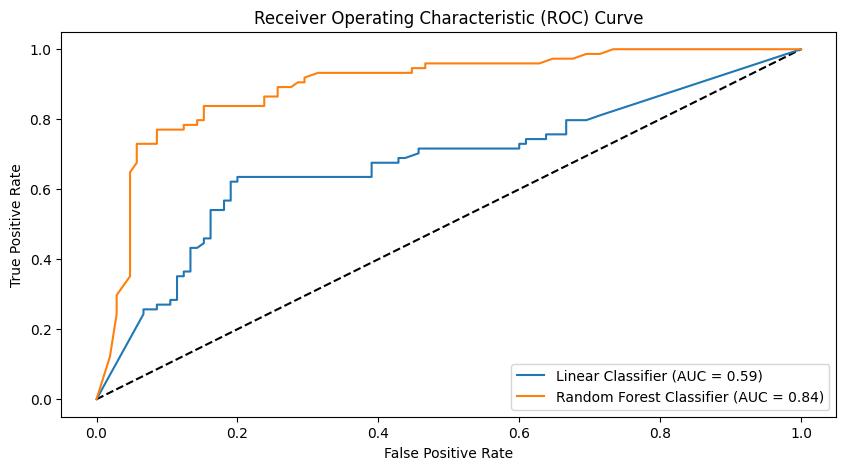

In [1710]:
# Plot ROC Curves
plt.figure(figsize=(10, 5))
plt.plot([0, 1], [0, 1], 'k--')

# Linear Classifier ROC Curve
plt.plot(fpr_sgd, tpr_sgd, label='Linear Classifier (AUC = {:.2f})'.format(roc_auc_sgd))

# Random Forest Classifier ROC Curve
plt.plot(fpr_rf, tpr_rf, label='Random Forest Classifier (AUC = {:.2f})'.format(roc_auc_rf))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

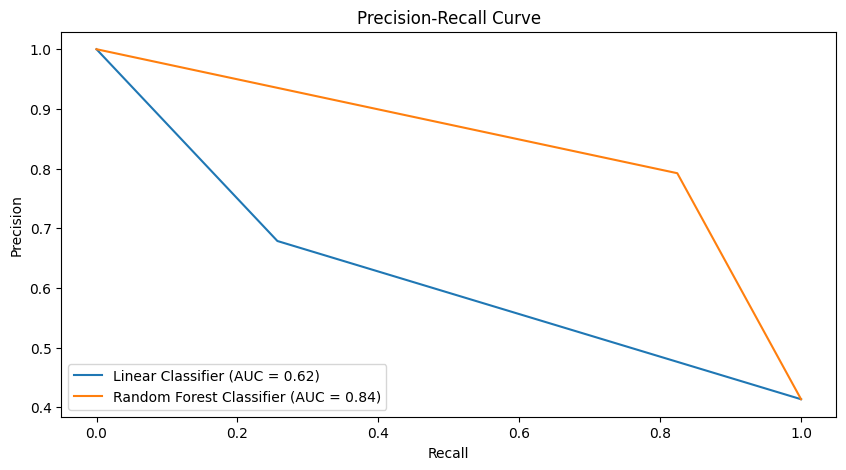

Linear Classifier ROC-AUC: 0.5855212355212355
Random Forest Classifier ROC-AUC: 0.8359716859716859
Linear Classifier PR-AUC: 0.6212953775802937
Random Forest Classifier PR-AUC: 0.8445789074280694


In [1711]:

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 5))
plt.plot(recall_sgd, precision_sgd, label='Linear Classifier (AUC = {:.2f})'.format(pr_auc_sgd))

plt.plot(recall_rf, precision_rf, label='Random Forest Classifier (AUC = {:.2f})'.format(pr_auc_rf))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print AUC values
print("Linear Classifier ROC-AUC:", roc_auc_sgd)
print("Random Forest Classifier ROC-AUC:", roc_auc_rf)
print("Linear Classifier PR-AUC:", pr_auc_sgd)
print("Random Forest Classifier PR-AUC:", pr_auc_rf)